In [3]:
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns

import string
import copy
import re
import nltk

nltk.download('words')

[nltk_data] Error loading words: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


False

In [4]:
with open('possibleWords.txt') as file:
    possible_answers = file.readlines()

possible_answers = possible_answers[0].split(',')
list_possible_answers = []
for answer in possible_answers:
    cleaned_answer = re.sub(r'[^A-Z]', '', answer.upper())
    list_possible_answers.append(cleaned_answer)
list_possible_answers.sort()

In [5]:
five_letter_words_df = pd.DataFrame(data=[list(w) for w in list_possible_answers],
                          columns=[f'letter_{i+1}' for i in range(5)])
five_letter_words_df['word'] = list_possible_answers
five_letter_words_df.head()

,letter_1,letter_2,letter_3,letter_4,letter_5,word
0,A,B,A,C,K,ABACK
1,A,B,A,S,E,ABASE
2,A,B,A,T,E,ABATE
3,A,B,B,E,Y,ABBEY
4,A,B,B,O,T,ABBOT


In [6]:
letter_counter = {i+1: Counter(five_letter_words_df[f'letter_{i+1}']) for i in range(5)}
letter_counter[1]

Counter({'S': 366,
         'C': 198,
         'B': 173,
         'T': 149,
         'P': 142,
         'A': 141,
         'F': 136,
         'G': 115,
         'D': 111,
         'M': 107,
         'R': 105,
         'L': 88,
         'W': 83,
         'E': 72,
         'H': 69,
         'V': 43,
         'O': 41,
         'N': 37,
         'I': 34,
         'U': 33,
         'Q': 23,
         'J': 20,
         'K': 20,
         'Y': 6,
         'Z': 3})

In [7]:
class Game:
    def __init__(self, df_all_5l_words):
        self.possible_letters = list(string.ascii_uppercase)
        
        self.dict_misplaced_letters = Counter()
        self.df_possible_5l_words = df_all_5l_words.copy(deep=True)
        
        self.dict_letters = {x + 1: None for x in range(5)}
        
        self.dict_letter_counts = {x + 1: Counter(df_all_5l_words[f'letter_{x + 1}']) for x in range(5)}
        

    def calculate_freq_score(self, letters: str) -> int:
        letters = letters.upper()
        assert len(letters) == 5, 'Word must be 5 characters long'
    
        score = sum(self.dict_letter_counts[i+1][l] for i, l in enumerate(letters))
        return score
        
    
    def guess(self):
        # First, reset letter counts
        for i in range(5):
            self.dict_letter_counts[i+1] = Counter(self.df_possible_5l_words[f'letter_{i+1}'])
        
        # Vectorize frequency score function to make it run faster
        vect_calculate_freq_score = np.vectorize(self.calculate_freq_score)
        
        self.df_possible_5l_words['freq_score'] = vect_calculate_freq_score(self.df_possible_5l_words['word'])
        
        self.df_possible_5l_words = self.df_possible_5l_words.sort_values(by='freq_score', ascending=False)
        return self.df_possible_5l_words
    
    
    def check_misplaced_letters(self, word: str) -> bool:
        
        word = re.sub(r'[^A-Z]', '', word.upper())
        assert len(word) == 5, 'Word must be 5 characters long'
        
        # Break into letters
        list_word = list(word)
        
        # Get indices (1 indexed) of positions that have not yet been solved
        not_solved = [key for key, value in self.dict_letters.items() if value is None]
        
        # Filter list of words for those not yet solved, removing 1 from the index as our letters are 1 indexed
        list_word_unsolved = [list_word[i-1] for i in not_solved]
        
        # Check counts
        dict_count_letters = Counter(list_word_unsolved)
        
        # Compare to dictionary of misplaced letters
        valid = True
        for check_key, check_value in self.dict_misplaced_letters.items():
            if dict_count_letters[check_key] < check_value:
                valid = False
                
        return valid
        
    
    def update(self, guess: str, results: list):
        
        guess = re.sub(r'[^A-Z]', '', guess.upper())
        assert len(guess) == 5, 'Guess must be 5 characters long'
        assert len(results) == 5, 'Results list must contain 5 items'
        assert all([n in [0,1,2] for n in results]), 'Results list must only contain ints 0, 1, or 2'
        
        # Convert guess into list of letters
        list_guess = list(guess.upper())
        
        # Zip with results
        df_guess_results = pd.DataFrame(data=list(zip(list_guess, results)),
                                        columns=['letter', 'result'],
                                        index=np.arange(1,6))
        
        # To prevent iterating through already solved letters
        already_solved = [key for key, value in self.dict_letters.items() if value is not None]
        

        # Update correct answers
        df_corr_answers = df_guess_results.query('result==2')
        if df_corr_answers.shape[0] > 0:
            for idx, row in df_corr_answers.iterrows():
                
                # Prevent updates for previously solved letters
                if idx in already_solved:
                    pass
                else:
                    corr_letter = row['letter']
                    self.dict_letters[idx] = corr_letter
                
                    # If correct letter was previously guessed as a misplaced letter, remove it
                    if corr_letter in self.dict_misplaced_letters.keys():
                        self.dict_misplaced_letters[corr_letter] -= 1
                        
                    # And filter dataframe of possible words
                    self.df_possible_5l_words = self.df_possible_5l_words.query(f'letter_{idx}=="{corr_letter}"')

          
        # Add misplaced letters to our list, if it's a new letter
        df_mispl_answers = df_guess_results.query('result==1')
        if df_mispl_answers.shape[0] > 0:
            
            # Filter dataframe to remove any words that have the misplaced letter in that column
            for idx, row in df_mispl_answers.iterrows():
                mispl_letter = row['letter']
                self.df_possible_5l_words = self.df_possible_5l_words.query(f'letter_{idx}!="{mispl_letter}"')  
            
            # Check how many we have of each letter that's misplaced
            guess_mispl_letters = df_mispl_answers['letter'].values
            dict_guess_mispl_letters = Counter(guess_mispl_letters)
            
            # Then update our dictionary of misplaced letters
            for key, value in dict_guess_mispl_letters.items():
                self.dict_misplaced_letters[key] = value   
            
            # Filter dataframe for words containing at least the count of the misplaced letters
            vect_check_misplaced_letters = np.vectorize(self.check_misplaced_letters)
            self.df_possible_5l_words['valid'] = vect_check_misplaced_letters(self.df_possible_5l_words['word'])
            self.df_possible_5l_words = self.df_possible_5l_words.query('valid == True')
            self.df_possible_5l_words = self.df_possible_5l_words.drop('valid', axis=1)    
        
        
        # Remove any incorrect letters from the list to guess from, if letter isn't in misplaced list
        df_wrong_answers = df_guess_results.query('result==0')
        if df_wrong_answers.shape[0] > 0:
            
            # Ensure we don't double count
            for l in df_wrong_answers['letter'].unique():
                if self.dict_misplaced_letters[l] == 0:
                    self.possible_letters.remove(l)
                
                
        # Finally, update list of possible 5 letter words by removing all rows where
        # for letters yet to be guessed, they don't fall in the list of possible letters
        yet_to_solve = [key for key, value in self.dict_letters.items() if value is None]
        for position in yet_to_solve:
            
            # Check all letters in a given position
            position_letters = self.df_possible_5l_words[f'letter_{position}']
            
            # Return a boolean list of whether that list is in the possible values or not
            position_in_possible_letters = [l in self.possible_letters for l in position_letters]
            
            # Filter
            self.df_possible_5l_words = self.df_possible_5l_words[position_in_possible_letters].copy(deep=True)


In [8]:
def play_game(target_word, df_possible_words, debug=False):
    target_word = re.sub(r'[^A-Z]', '', target_word.upper())
    assert len(target_word) == 5, 'target_word must be 5 characters long'
    assert all(df_possible_words.columns == ['letter_1', 'letter_2', 'letter_3', 'letter_4', 'letter_5', 'word']), "Dataframe must have columns ['letter_1', 'letter_2', 'letter_3', 'letter_4', 'letter_5', 'word']"
    
    TestGame = Game(df_possible_words)
    
    target_letters = list(target_word)
    
    for guess_turn in range(6):
        
        # Return word with highest frequency count across all letters as the guess
        guess_word = TestGame.guess().iloc[0]['word'] 
        guess_letters = list(guess_word)
        
        # Dictionary of results at each position
        dict_results = defaultdict(str)
        for i in range(5):
            dict_results[i] = None
        
        # First assign correct letters with a score of 2
        for pos, guess_letter in enumerate(guess_letters):
            if guess_letter == target_letters[pos]:
                dict_results[pos] = 2
        
        # For remaining letters, if they appear within the target word - count them as misplaced
        # Otherwise, count them as wrong
        remaining_pos = [key for key, value in dict_results.items() if value is None]
        if len(remaining_pos) == 0:
            # Guess correct
            results = [2, 2, 2, 2, 2]
        else:
            # Tag remaining letters in our guess and their position
            # Need to use list as we may have duplicate keys (same letter in >1 position)
            remaining_guess_letters = [[guess_letters[i], i] for i in remaining_pos]
            
            # Tag remaining letters in the answer, and create a Counter dictionary
            remaining_target_letters = [target_letters[i] for i in remaining_pos]
            dict_target_letter_count = Counter(remaining_target_letters)
            
            # Loop through our remaining guess letters
            for [letter, pos] in remaining_guess_letters:
                # Check they appear in the target word at least once
                if dict_target_letter_count[letter] > 0:
                    
                    # Subtract from target letter count, to prevent double counting
                    # e.g. tag first 'E' as misplaced, second 'E' as wrong when guessing GREET for
                    # target word STAGE
                    dict_target_letter_count[letter] -= 1
                    
                    # Update results
                    dict_results[pos] = 1
                else:
                    dict_results[pos] = 0
             
            # Turn into list 
            results = list(dict_results.values())
            
        # Finally, produce results as a list and pass back to game to update
        if debug:
            print(f'Turn {guess_turn+1}, guess {guess_word}, results {results}\n')
        if np.sum(results) == 10:
            if debug:
                print('Game won!')
            else:
                # Used for tracking metrics
                return (target_word, guess_turn+1)
            break
            
        # If the game isn't solved by turn 6, return "7" as the number of guesses
        if guess_turn == 5:
            if debug:
                print('Unsolved!')
            else:
                # Used for tracking metrics
                return (target_word, 7)
        
        TestGame.update(guess_word, results)

In [9]:
rand_keys = np.random.randint(low=0, high=len(list_possible_answers), size=2)
rand_words = [list_possible_answers[k] for k in rand_keys]

for i, word in enumerate(rand_words):
    print(f'**GAME {i}: target {word}**')
    play_game(word, five_letter_words_df, debug=True)
    print('\n')

**GAME 0: target DOLLY**
Turn 1, guess SLATE, results [0, 1, 0, 0, 0]

Turn 2, guess GOLLY, results [0, 2, 2, 2, 2]

Turn 3, guess DOLLY, results [2, 2, 2, 2, 2]

Game won!


**GAME 1: target EATER**
Turn 1, guess SLATE, results [0, 0, 1, 1, 1]

Turn 2, guess CATER, results [0, 2, 2, 2, 2]

Turn 3, guess EATER, results [2, 2, 2, 2, 2]

Game won!




100%|██████████| 2315/2315 [00:30<00:00, 76.37it/s] 

Average turns taken: 3.67
Unsolved words: 13
       word  attempts
0     ABACK         5
1     ABASE         4
2     ABATE         3
3     ABBEY         4
4     ABBOT         4
...     ...       ...
2310  YOUNG         3
2311  YOUTH         4
2312  ZEBRA         4
2313  ZESTY         3
2314  ZONAL         3

[2315 rows x 2 columns]


<Axes: xlabel='attempts', ylabel='Count'>

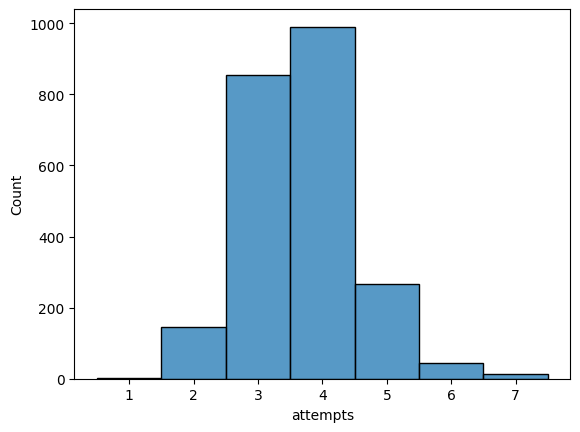

In [10]:
all_results = []
for answer in tqdm(list_possible_answers):
    all_results.append(play_game(answer, five_letter_words_df, debug=False))

df_all_results = pd.DataFrame(data=all_results,
                              columns=['word', 'turns_taken'])

print('Average turns taken: {:.2f}'.format(df_all_results['turns_taken'].mean()),
      'Unsolved words: {}'.format(df_all_results.query('turns_taken==7').shape[0]),
      sep='\n')

df_all_results.columns = ['word', 'attempts']
print(df_all_results)

sns.histplot(data=df_all_results['attempts'],
             discrete=True)

In [21]:
## df_all_results.query('turns_taken==7')

In [20]:
# Initialise game
WordleGame = Game(five_letter_words_df)

# Loop through turns
for turn in range(6):
    
    # Our guess will be the word with the highest letter frequency
    guess_word = WordleGame.guess().iloc[0]['word']
    print(f'Turn {turn+1}, guess: {guess_word}, results:')
    
    # This is where you put in your game results
    guess_results = input() 
    print(guess_results + '\n')
    list_guess_results = [int(n) for n in guess_results.split(',')]
    if np.sum(list_guess_results) == 10:
        print('Game won!')
        break
    
    # Update game
    WordleGame.update(guess_word, list_guess_results)

Turn 1, guess: SLATE, results:
1,0,0,0,2

Turn 2, guess: NOOSE, results:
1,0,0,1,2

Turn 3, guess: ENSUE, results:
2,2,2,2,2

Game won!
